In [80]:
from sklearn.datasets import fetch_lfw_pairs
import torch
# from torch.utils.data import Dataset
from torchvision import transforms , datasets
from Dataset import LFWtripletDataset
import matplotlib.pyplot as plt


In [81]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Total People: 5758
Total Images: 13233
Max Images for a Person: 530
Total People with one Image: 4069
Total People with multiple Images: 1680


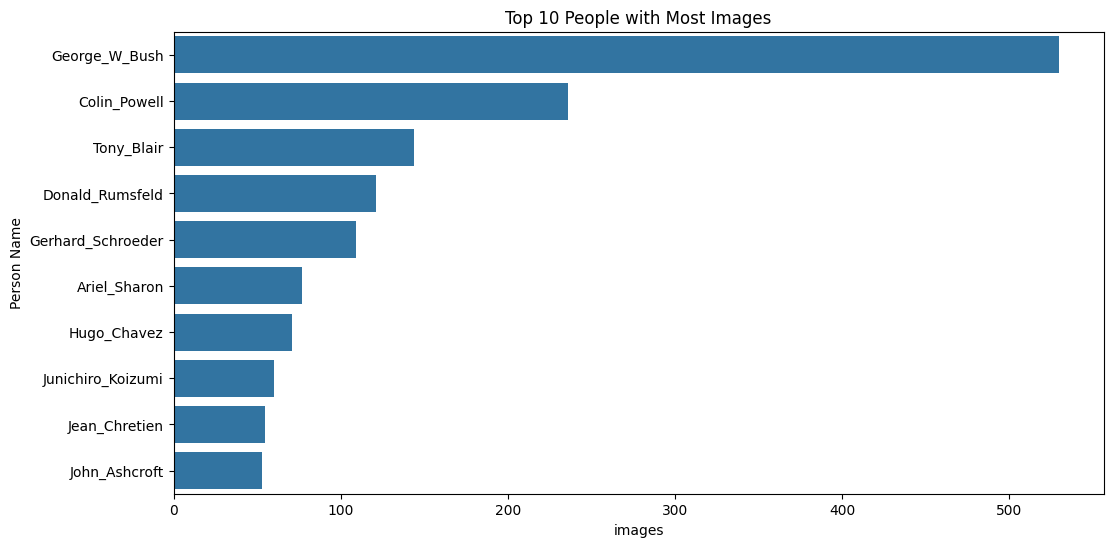

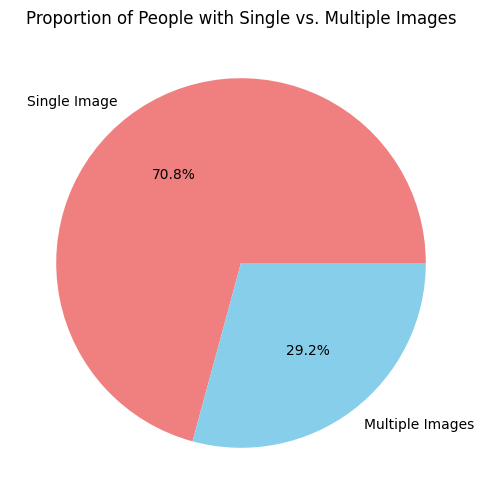

In [83]:
root_dir = "data/lfw-py"

dataset = LFWtripletDataset(root_dir=root_dir, transform=None)
dataset.statistics()


### Triplet Sampling Strategy

Since **70% of the dataset** consists of individuals with only a single image, these individuals cannot be used for anchor-positive pairing.  

To construct triplets:  
- For the **1,680 individuals** who have multiple images, each image can serve as an **anchor**.  
- A **positive sample** is randomly selected from another image of the same person.  
- A **negative sample** is randomly chosen from the **4,069 individuals** who have only one image, ensuring that the negative comes from a different identity.  

This approach in our opinion will maximize the use of available data while maintaining a meaningful triplet structure for training.
ng.


In [84]:
transforms = transforms.Compose([
    transforms.ToTensor()    # Convert PIL image to tensor
])
train_dataset = LFWtripletDataset(root_dir=root_dir, split="train", transform=transforms)
print(train_dataset.__len__())
test_dataset = LFWtripletDataset(root_dir=root_dir, split="test", transform=transforms)
print(test_dataset.__len__())

6671
2493


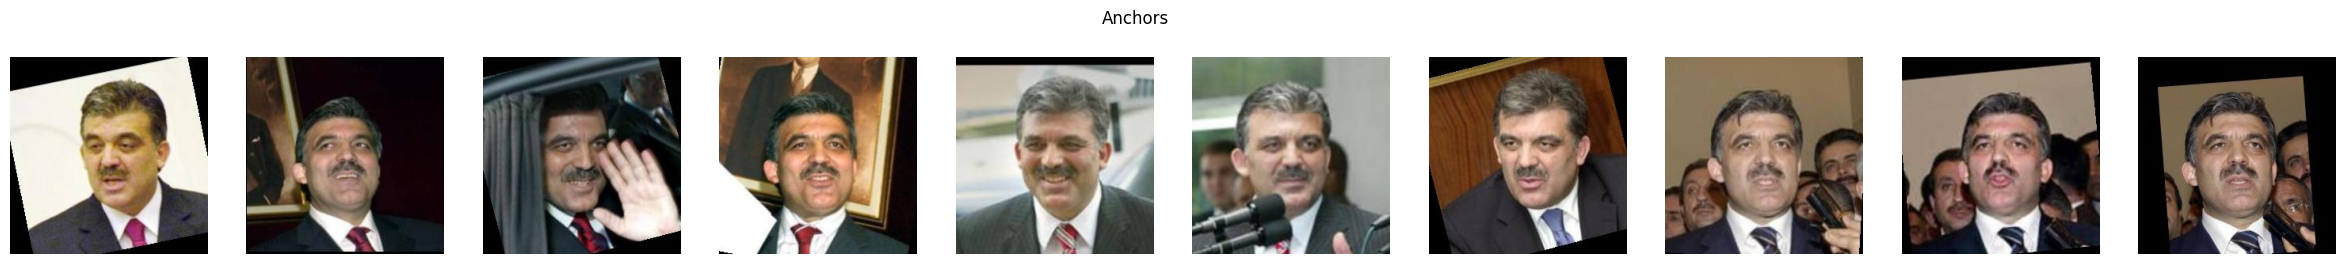

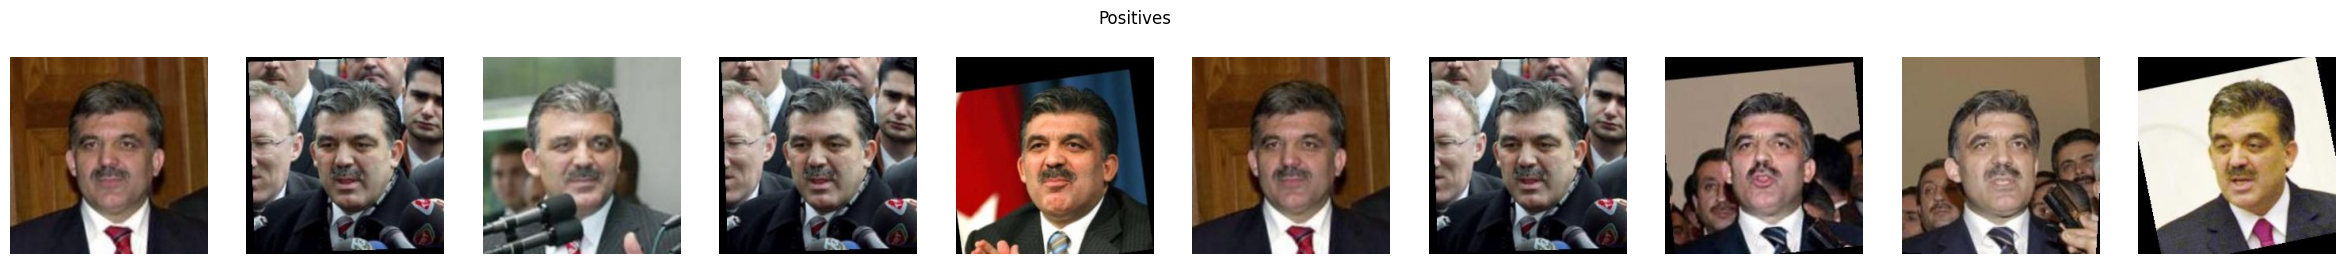

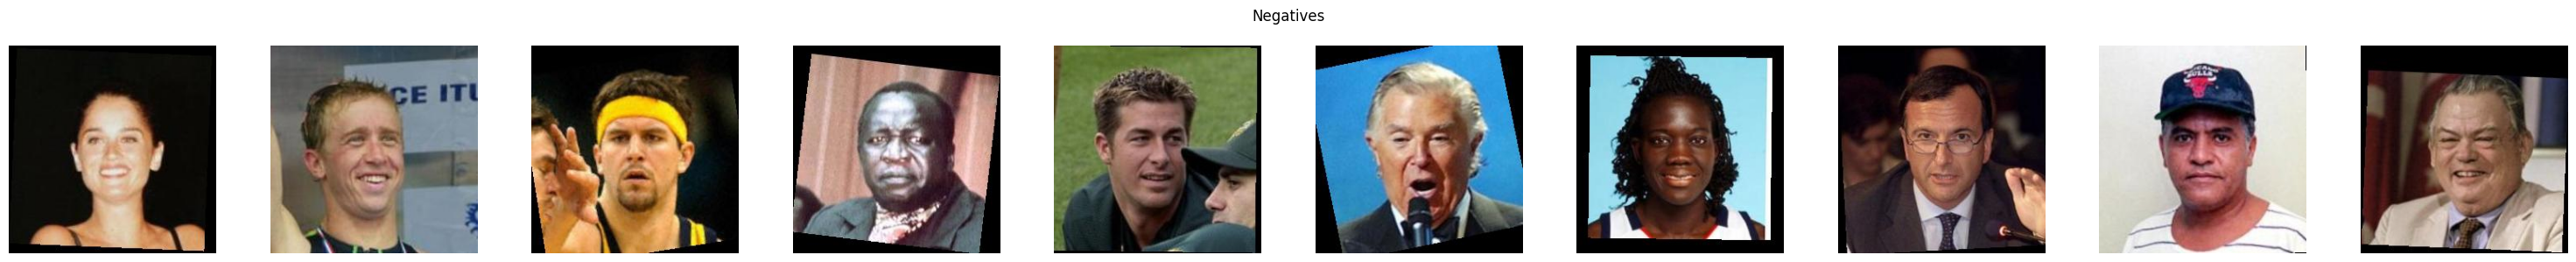

In [78]:
fig_anchors, anchors = plt.subplots(1, 10, figsize=(30, 3))
fig_pos, positives = plt.subplots(1, 10, figsize=(30, 3))
fig_neg, negatives = plt.subplots(1, 10, figsize=(30, 3))

for i in range(10):
    # Get the anchor, positive, and negative images from the dataset
    (anchor, positive, negative), _ = test_dataset[i]
    
    # Convert from (C, H, W) to (H, W, C) 
    anchor = anchor.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
    positive = positive.permute(1, 2, 0).numpy()
    negative = negative.permute(1, 2, 0).numpy()
    
    # Display the images
    anchors[i].imshow(anchor)
    anchors[i].axis("off")
    
    positives[i].imshow(positive)
    positives[i].axis("off")
    
    negatives[i].imshow(negative)
    negatives[i].axis("off")

# Set titles
fig_anchors.suptitle("Anchors")
fig_pos.suptitle("Positives")
fig_neg.suptitle("Negatives")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
